In [1]:
import pandas as pd
import numpy as np
import pickle
import random
from sklearn import cluster
import scipy.cluster.hierarchy as sch
from matplotlib import pyplot as plt
from numpy import mean
from functools import reduce

'''
分类报告
sklearn.metric.classification_report(实际输出，预测输出)->分类报告

验证曲线：
模型的F1得分和创建该模型时选用的某个超参数之间的关系
sklearn.model_selecttion.validation_curvel(模型对象,输入集,输出集，超参数名，超参数值表，cv=验证次数)->
训练集得分矩阵，测试集得分矩阵


通过方法 去验证 超参数的取值，进行对比

学习曲线：
模型的F1得分和训练该模型时择个超参数之间的关系

sklearn.model_selecttion.learning_curvel(模型对象,输入集,输出集，训练集大小列表，cv=验证次数)->
训练集得分矩阵，测试集得分矩阵

'''

In [3]:
#独热编码
def oneHotEncoding(df, old_field):
    distinct_vals = list(set(reduce(lambda x,y:x+y,df[old_field])))
    cnt = len(distinct_vals)
    new_fields = [old_field+'_'+str(i) for i in range(cnt)]
    for i in range(cnt):
        df[new_fields[i]] = 0
        df[new_fields[i]] = df[old_field].map(lambda x: int(distinct_vals[i] in x))
    del df[old_field]
    return 1

#归一化处理
def normalization(df,var,method='min-max'):
    '''
    :param df,var: the dataframe and column that need to be normalized. Please make sure it is not a constant, and also not empty
    :param method: normalization method
    :return: the normalized result or -1 for error input
    '''
    x = df[var]
    new_field = var + "_norm"
    if method == 'min-max':
        x_min = min(x)
        x_max = max(x)
        d = x_max - x_min
        df[new_field] = [(i-x_min)*1.0/d for i in x]
        del df[var]
        return 1
    elif method == 'zero-score':
        mu = np.mean(x)
        std = np.std(x)
        df[new_field] = [(i - mu) * 1.0 / std for i in x]
        del df[var]
        return 1
    else:
        print ("Please specify the normalization method: min-max or zero-score")
        return -1

def makeupMissing(x,replaceVal):
    if np.isnan(x):
        return replaceVal
    else:
        return x

def minkovDist(x,y,p=2):
    '''
    :param x,y: the numpy arrays of two samples
    :param p: the degree of distance
    :return: the distance, or -1 if p is less than 1
    '''
    if p>=1:
        return (sum((x-y)**p)*1.0)**(1.0/p)
    else:
        print('p must be larger than or equal to 0')
        return -1
# 层次聚类直接用scipy一个包 做
'''
不能进行聚类计算的特征是不在dataSet里面
并不包含不能用来做聚类的列
k:想要聚类的数字
当前方法是 Kmeans 的做法：
如果是层次聚类scipy里面的包做
返回结果：当前类的划分 每一类的中心是什么 当次聚类结果的cost是多少？
'''
def KmeansAlgo(dataset, k):
    '''
    :param dataset: the dataset of clustering 聚类数据集
    :param k: the number of clusters 集群数量 
    :return: the group label of each sample, the centroids and the cost
             每个样本的组标签，质心和成本
    '''
    #查看有多少个样本
    N = dataset.shape[0]
    #
    label = [0]*N
    # randomly select k samples as the initial centroids
    # 随机选择k个样本作为初始质心
    #初始化均值向量的公式 sample 随机获取数据
    '''
    初始化的均值向量是随机选取的，可以使用更好的方法做
    '''
    centroidsIndex = random.sample(range(N),k)
    #随机初始化的均值向量
    centroids = [dataset[i,] for i in centroidsIndex]
    #一旦发现 某一次循环之后，所有的类簇里面 的几何中心 它的均值向量不在发生改变
    #不再发生改变 预先设置开关
    centroidsChanged = True
    
    while(centroidsChanged):
        centroidsChanged = False
        #Calculate the Minkovski distance between each point and the centriods
        #计算每个点与中心点之间的Minkovski距离
        #Assign the point to the group with min distance to the centroid of the group
        #将点指定给距离组的质心最小距离的组
        '''
        贪心的过程，把所有样本对于均值向量的距离都计算出来
        '''
        for i in range(N):
            '''
            由于Kmeans是贪心算法，需要计算每一个样本距离所有的
            均值向量的距离是多少，保存下距离，看一下样本点是对于哪一个类
            对
            '''
            dist_to_cent = [minkovDist(dataset[i,].getA()[0], centroid.getA()[0]) for centroid in centroids]
            #对于最近的均值向量的那个类 就是属于那个类别
            label[i] = dist_to_cent.index(min(dist_to_cent))
        #Update the centroids using geometric centroid in the group
        #使用组中的几何质心更新质心
        for j in range(k):
            #每个类里面的几何中心
            position = [p for p in range(N) if label[p] == j]
            clusterGroup = dataset[position]
            # 每个类新的类别中心
            newCents = np.mean(clusterGroup, axis=0)
            #Judge whether the centrod is updated
            #判断centrod是否更新 
            '''
            判断新的中心 和 旧的中心的距离，如果差别比较大 大于预先设计的值
            如果几何中心发生改变，就用新的几何中心代表旧的几何中心
            并且进行新的循环
            
            '''
            if minkovDist(newCents.getA()[0], centroids[j].getA()[0]) > 0.00001:
                centroidsChanged = True
                centroids[j] = newCents
            else:
                centroidsChanged = False
    #calculate the cost function 计算成本函数 损失函数
    #每一个类里面 每一个样本到他类的中心的平方和
    cost = 0
    for i in range(N):
        centroid = centroids[label[i]]
        dist_to_cent = minkovDist(dataset[i,].getA()[0], centroid.getA()[0])
        cost += dist_to_cent**2
    cost = cost/N
    
    #返回结果：当前类的划分 每一类的中心是什么 当次聚类结果的cost是多少？
    return {'group':label, 'centroids':centroids, 'cost':cost}

In [37]:
# 读取数据 数据预处理
loan_table = pd.read_csv('input/loan_details.csv', header = 0, encoding='gb2312')
#cust_table不是必需的。仅仅只是做了一些筛选，筛选出我们关心的客户
cust_table = pd.read_csv('input/customer_table.csv', header = 0, encoding='gb2312')

In [38]:
# 随机选取数据
# loan_table1 = loan_table.head(1000)
# cust_table1 = cust_table.head(1000)
loan_table = loan_table.sample(n=6000) 
#
cust_table = cust_table.sample(n=6000)
# print(cust_table.shape)
# print(loan_table.shape)
cust_table.head()

,CUST_ID,贷款五级分类,贷款期限,合同金额,贷款余额,贷款数量,城乡标志,省内外标志,资信等级,性别,...,转入主要渠道代码,转入渠道数量,转出累计交易金额,转出累计交易量,转出主要渠道交易金额,转出主要渠道代码,转出渠道数量,亲属储蓄月均余额,亲属理财月均余额,亲属保险月均余额
13497,89230ad670a541318d1d5b50f2557364,1,120.0,110000,85177.15,1,乡,省内,3.0,女,...,17.0,2.0,400.0,2.0,400.0,22.0,1.0,0.09,0.0,0.0
78017,f7aee3dcfef54f59a485d107f58d39ad,1,180.0,180000,167395.64,1,乡,省内,4.0,男,...,17.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
120924,K1121208169722,1,84.0,130000,62368.63,1,乡,省内,5.0,女,...,20.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
107235,K1121104273189,1,240.0,200000,166953.13,1,乡,省内,5.0,男,...,2.0,1.0,NaN,NaN,NaN,NaN,NaN,0.39,0.0,0.0
7887,7f5027ef07864f658bcf9ac6b419136b,1,180.0,200000,165159.94,1,乡,省内,2.0,男,...,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
#获取cust_table['CUST_ID'] 删除缺失值 并生成新的DataFrame 对象
print(cust_table['CUST_ID'].shape)
cust_id = cust_table['CUST_ID'].drop_duplicates().to_frame(name='CUST_ID')
print(cust_id.shape)
print('--------')
print(cust_id.columns)
cust_id.columns = ['CUST_ID']
print(cust_id.columns)

loan_table_cust = cust_id.merge(loan_table, on='CUST_ID',how='inner')
print(loan_table_cust.shape)
# 发现cust_id 不止一种记录 ，两个原因 
#1、有客户有不止一种的贷款时间 2、重复提交资料（此时用没有缺失的数据代替）
# 缺失的数据
id_freq = loan_table_cust.groupby(['CUST_ID'])['CUST_ID'].count()
print(id_freq)
id_freq_2 = id_freq.to_dict()
id_freq_3 = [k for k, v in id_freq_2.items() if v > 1]
print('ooooppppppppppppppp')
print(id_freq_3)
id_freq_4 = pd.DataFrame({'CUST_ID':id_freq_3})
print('123123-----')
print(id_freq_4)

(6000,)
(5995, 1)
--------
Index(['CUST_ID'], dtype='object')
Index(['CUST_ID'], dtype='object')
(198, 25)
CUST_ID
723c01b46b944f8186c9d87ec8915b26    1
73179cd1a79b4bac8d0fd0ff37fe45d5    1
745d8382468a4c5b8fea1ab68e5eca56    1
74bdd887221c49a8bdbf54ef3103ec0d    1
76f906e82eba41399732a5498f5dc59c    1
77a44b343fcd42289e408c54cba78262    1
78bf8a7893074a5cbe126dfe64072acb    1
78e78603773944979b3b39d4bdf28d8e    1
78fa1c12fe0e4a129ecdb146b63b0b68    1
7b87fb12b92e433ba3fccb71bf175be0    1
7bbeed0f196c4a8991c4b2eed2856847    1
802231403f294c8cb010bd012bf6028c    1
80cc440505f34baca41f6cc6f8eea10a    1
8100ee5bc200431180afb2bf8b64522a    1
81323d2aa2fa4dddab88ba0a74b0ecae    1
8162ab8b97df4bbb9f37da430fee7f78    1
81c07c4d4c2e410e8b5f0e61034aa9b9    1
83508add930c49c5a5ff41f1e983b426    1
836161f398d24fed87de2016d921f09a    1
86f491e3505d4f04a89c393fd1e5113b    1
89bef883c7dd41a4a097b3d8dc7995cc    1
89ef04804d1b4c5b8b2ed115d958ea32    1
8b8aca8432a9454687b1bf8d1cf5a448    1
8fbb72f4b6f

In [63]:
'''
ID的一些副本是由于信息再提交。对于这些申请人 
Some of the duplicates of ID are due to information re-submmission. For these applicants,
the 'CUST_ID','Loan_Type','Loan_Term','Start_Date','End_Date','Loan_Amt','Undisbursed_Amt','Business_Type_Code'
are the same
'''

dup_records = id_freq_4.merge(loan_table, on='CUST_ID',how='inner')[['CUST_ID','Loan_Type','Loan_Term','Start_Date','End_Date',
                                                                     'Loan_Amt','Undisbursed_Amt','Business_Type_Code']]

# print(dup_records)
#First, we remove the dupliated records in dup_records
#首先，我们删除dup_records中的重复记录
dup_records2 = dup_records.drop_duplicates()
id_dup = dup_records2.groupby(['CUST_ID'])['CUST_ID'].count().to_dict()

# print(id_dup)
id_dup_1 = [k for k,v in id_dup.items() if v == 1]
id_dup_1_df = pd.DataFrame({'CUST_ID':id_dup_1})
print(id_dup_1_df)
drop_dup_1 = pd.merge(id_dup_1_df,loan_table, on= 'CUST_ID',how='left')
drop_dup_1b = drop_dup_1.groupby('CUST_ID').last()
print('-----------')
# print(drop_dup_1)
# print(drop_dup_1b)
print('1111-----')
# print(id_freq.head())
id_all = list(id_freq.index)
id_non_dup = [i for i in id_all if i not in set(drop_dup_1b.index)]
id_non_dup_df = pd.DataFrame({'CUST_ID':id_non_dup})
id_non_dup_df_2 = pd.merge(id_non_dup_df,loan_table, on= 'CUST_ID',how='left')

print('222222-----')
id_loans = pd.concat([id_non_dup_df_2,drop_dup_1b])

### Second, we make up the missing value in the dataframe
###其次，我们弥补了数据框中的缺失值
### make up the missing value in Interest_Payment
### 弥补Interest_Payment中的缺失值 9 进行补缺
temp = id_loans.apply(lambda x: int(makeupMissing(x.Interest_Payment,9)), axis=1)
id_loans['Interest_Payment'] = temp

### make up the missing value in Credit_Level
### 弥补Credit_Level中的缺失值 0表示缺失的状态
temp = id_loans.apply(lambda x: int(makeupMissing(x.Credit_Level,0)), axis=1)
id_loans['Credit_Level'] = temp
print('333333-----')

Empty DataFrame
Columns: [CUST_ID]
Index: []
-----------
1111-----
222222-----
333333-----


In [64]:
'''
initially, we convert the data from loan level to customer level. For the customers with mulitple loans,
we use the list to capture the details 
最初，我们将数据从贷款级别转换为客户级别。对于有多种贷款的客户，
我们使用该列表来捕获详细信息
比如有人有两种不同的不同的产品，对于两种产品的不同利率 用 列表表示出来
'''

all_vars = list(id_loans.columns)
all_vars.remove('CUST_ID')
for var in all_vars:
    id_loans[var] = id_loans[var].apply(lambda x: [x])

# 当前表里面所有的 CUST_ID 都是唯一的
id_loans_group = id_loans.groupby('CUST_ID').sum()
print('444444-----')
#file_id_loans_group.close()
#file_id_loans_group = open('/Users/Downloads/数据/银行客群聚类/processed data/id_loans_group.pkl','r')
#id_loans_group = pickle.load(file_id_loans_group)
#file_id_loans_group.close()

#### Derive the various features using loan detail table ####
# Also we normalize the variables if necessary
# No. of loan types
'''
查看每一个人有多少种不同的贷款
特征衍生
'''
# print(id_loans_group.head())
print('-----=====')

var1 = id_loans_group.apply(lambda x: len(set(x.Loan_Type)),axis=1)
print(lambda x: len(set(x.Loan_Type)))
print()
print('9999999999999999')
# print(var1.head())
var1 = var1.to_frame(name='No_Loan_Types')
print('sssssssssssssssss')
# print(var1.head())
#count of loans 贷款数量 多少个不同的贷款
var2 = id_loans_group.apply(lambda x: len(x.Loan_Type),axis=1)
var2 = var2.to_frame(name='No_Loan')
print('77777-----')
#max of loan terms 最大贷款期限
var3a = id_loans_group.apply(lambda x: max(x.Loan_Term),axis=1)
var3a = var3a.to_frame(name='Max_Loan_Terms')

normalization(var3a, 'Max_Loan_Terms')

print('555555-----')
#min of loan terms 最低贷款期限
var3b = id_loans_group.apply(lambda x: min(x.Loan_Term),axis=1)
var3b = var3b.to_frame(name='Min_Loan_Terms')
normalization(var3b, 'Min_Loan_Terms')

#mean of loan terms 贷款期限的平均值
var3c = id_loans_group.apply(lambda x: mean(x.Loan_Term),axis=1)
var3c = var3c.to_frame(name='Mean_Loan_Terms')
normalization(var3c, 'Mean_Loan_Terms')
print('88888-----')

#total loan amount 贷款总额
#var4 = id_loans.groupby('CUST_ID').Loan_Amt.sum()
var4a = id_loans_group.apply(lambda x: sum(x.Loan_Amt),axis=1)
var4a = var4a.to_frame(name='Total_Loan_Amt')

444444-----
-----=====
<function <lambda> at 0x1a1a3bf158>

9999999999999999
sssssssssssssssss
77777-----
555555-----
88888-----


In [65]:
#mean loan amount 平均贷款额
var4b = id_loans_group.apply(lambda x: mean(x.Loan_Amt),axis=1)
var4b = var4b.to_frame(name='Mean_Loan_Amt')

#total Undisbursed_Amt  Undisbursed_Amt总计

#var5 = id_loans.groupby('CUST_ID').Undisbursed_Amt.sum()
var5a = id_loans_group.apply(lambda x: sum(x.Undisbursed_Amt),axis=1)
var5a = var5a.to_frame(name='Total_Undisbursed_Amt')
print('99999999-----')
#mean Undisbursed_Amt
var5b = id_loans_group.apply(lambda x: mean(x.Undisbursed_Amt),axis=1)
var5b = var5b.to_frame(name='Mean_Undisbursed_Amt')

#ratio of total Undisbursed_Amt and total loan amount
#未支配总额与贷款总额之比 未还清的贷款总额 
var6a = pd.concat([var4a,var5a],axis=1)
var6a['Total_Undisbursed_to_Loan'] = var6a.apply(lambda x: x.Total_Undisbursed_Amt/x.Total_Loan_Amt,axis=1)
del var6a['Total_Undisbursed_Amt']
del var6a['Total_Loan_Amt']

#ratio of mean Undisbursed_Amt and mean loan amount
#平均Undisbursed_Amt与平均贷款额的比率
var6b = pd.concat([var4b,var5b],axis=1)
var6b['Mean_Undisbursed_to_Loan'] = var6b.apply(lambda x: x.Mean_Undisbursed_Amt/x.Mean_Loan_Amt,axis=1)
del var6b['Mean_Undisbursed_Amt']
del var6b['Mean_Loan_Amt']

99999999-----


In [66]:
#归一化处理
normalization(var4a,'Total_Loan_Amt')
print(var4a)
normalization(var4b,'Mean_Loan_Amt')
normalization(var5a,'Total_Undisbursed_Amt')
normalization(var5b,'Mean_Undisbursed_Amt')

print('aaaaaaaaa-----')
#min and max of interest rate of the single customer
#单个客户的最低和最高利率
var7a = id_loans_group.apply(lambda x: min(x.Interest_Rate),axis=1)
var7a = var7a.to_frame(name='Min_Interest_Rate')
normalization(var7a,'Min_Interest_Rate')

var7b = id_loans_group.apply(lambda x: max(x.Interest_Rate),axis=1)
var7b = var7b.to_frame(name='Max_Interest_Rate')
normalization(var7b,'Max_Interest_Rate')

# 将需要处理的特征 合并起来（主要是数值型的变量）
derived_features = pd.concat([var1,var2,var3a,var3b,var3c,var4a,var4b,var5a,var5b,var6a,var6b,var7a,var7b],axis=1)

#onehot encode the Business_Type_Code，Repay_Way， Interest_Payment，Rural，
#External_Ind，Credit_Level，Gender
'''
类别型的特征变量 
onehot编码Business_Type_Code，Repay_Way，Interest_Payment，
Rural，External_Ind，Credit_Level，Gender
'''
var_onehot_list = ['Business_Type_Code','Repay_Way','Interest_Payment','Rural','External_Ind','Credit_Level','Gender']
for var_onehot in var_onehot_list:
    var_onehot_df = id_loans_group[var_onehot]
    var_onehot_df = var_onehot_df.to_frame(name = var_onehot)
    oneHotEncoding(var_onehot_df, var_onehot)
    #将热读编码的结果和归一化的结果进行合并
    derived_features = pd.concat([derived_features,var_onehot_df],axis = 1)

#合并完毕热读编码和归一化后 最终是可以用来训练的数据

                                  Total_Loan_Amt_norm
CUST_ID                                              
723c01b46b944f8186c9d87ec8915b26             0.302103
73179cd1a79b4bac8d0fd0ff37fe45d5             0.235182
745d8382468a4c5b8fea1ab68e5eca56             0.244742
74bdd887221c49a8bdbf54ef3103ec0d             0.216061
76f906e82eba41399732a5498f5dc59c             0.082218
77a44b343fcd42289e408c54cba78262             0.024857
78bf8a7893074a5cbe126dfe64072acb             0.177820
78e78603773944979b3b39d4bdf28d8e             0.063098
78fa1c12fe0e4a129ecdb146b63b0b68             0.168260
7b87fb12b92e433ba3fccb71bf175be0             0.091778
7bbeed0f196c4a8991c4b2eed2856847             1.000000
802231403f294c8cb010bd012bf6028c             0.091778
80cc440505f34baca41f6cc6f8eea10a             0.110899
8100ee5bc200431180afb2bf8b64522a             0.330784
81323d2aa2fa4dddab88ba0a74b0ecae             0.531549
8162ab8b97df4bbb9f37da430fee7f78             0.072658
81c07c4d4c2e410e8b5f0e61034a

In [43]:
'''
Use the Kmeans clustering method
使用Kmeans群集方法

'''
#just for demonstration
#只是为了演示
M = 100 
# 选取前100个样本 
dataset = np.matrix(derived_features)[:M,]
derived_features.head()
# print(dataset)

,No_Loan_Types,No_Loan,Max_Loan_Terms_norm,Min_Loan_Terms_norm,Mean_Loan_Terms_norm,Total_Loan_Amt_norm,Mean_Loan_Amt_norm,Total_Undisbursed_Amt_norm,Mean_Undisbursed_Amt_norm,Total_Undisbursed_to_Loan,...,Rural_1,External_Ind_0,External_Ind_1,Credit_Level_0,Credit_Level_1,Credit_Level_2,Credit_Level_3,Credit_Level_4,Gender_0,Gender_1
CUST_ID,,,,,,,,,,,,,,,,,,,,,
71b08f3c59d6479ca44feb355bf654e0,1,1,0.310345,0.310345,0.310345,0.042146,0.042146,0.057534,0.057534,0.940770,...,0,0,1,0,0,0,1,0,0,1
72812612e6914c5a99511ac80a845460,1,1,0.413793,0.413793,0.413793,0.134100,0.134100,0.163749,0.163749,1.000000,...,0,0,1,0,0,1,0,0,0,1
7283003c192a460da18263a4a68b810c,1,1,0.310345,0.310345,0.310345,0.111111,0.111111,0.102087,0.102087,0.750493,...,0,0,1,0,0,1,0,0,0,1
7423811fcec44b5ca112f5aa2a4d5b8d,1,1,0.655172,0.655172,0.655172,0.164751,0.164751,0.192163,0.192163,0.972368,...,0,0,1,0,0,1,0,0,0,1
7553d30f8cc8420d80ef0fda6659c8ce,1,1,0.137931,0.137931,0.137931,0.011494,0.011494,0.013189,0.013189,0.579561,...,0,0,1,0,0,0,1,0,0,1


2
2.3750906388646214
3
2.103832243389805
4
2.084304618316417
5
1.9165820653045627
6
1.7984937083069221
[2.3750906388646214, 2.103832243389805, 2.084304618316417, 1.9165820653045627, 1.7984937083069221]


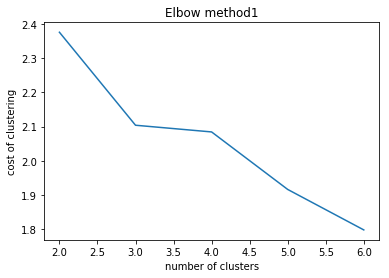

In [46]:
'''
Elbow 方法 
对于不同的聚类个数k，计算每个k下损失函数E = 
'''

cost = []
for k in range(2,7):
    #
    result = KmeansAlgo(dataset, k)
    print(k)
    print(result['cost'])
    cost.append(result['cost'])

print(cost)
# print('ccccccc-----')
plt.plot(range(2,7),cost[:5])
plt.xlabel("number of clusters")
plt.ylabel("cost of clustering")
plt.title("Elbow method1")
plt.show()

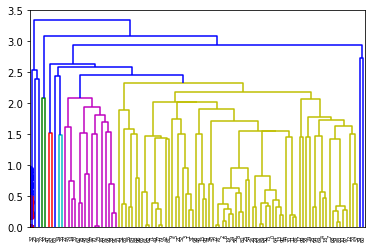

In [45]:


#3 clusters are suitable for the dataset
#群集适用于数据集
result = KmeansAlgo(dataset, 3)
featureCompared = np.matrix(np.zeros(dataset.shape[1]))
# print(M)
# print(len(result['group']))
# print(result['group'])
for l in range(3):
#     print(l)
#     groupIndex = [i for i in range(M) if result['group'][i]==l]
    groupIndex  = []
    for i in range(M):
        if result['group'][i]==l:
            groupIndex.append(i)

#     print(groupIndex)
    temp = dataset[groupIndex]
    featureMean = np.mean(temp, axis = 0)
    featureCompared = np.row_stack((featureCompared,featureMean))
np.delete(featureCompared,0,0)

# print('dddddddd-----')
cols = ['g','b','r']
for l in range(3):
    groupIndex = [i for i in range(M) if result['group'][i]==l]
    x1 = dataset[groupIndex,2].getA()
    x2 = dataset[groupIndex,11].getA()
    p=plt.scatter(x1,x2,color = cols[l])

### Hierarchy Clustering
#层次结构聚类
disMat = sch.distance.pdist(dataset,'euclidean')
Z=sch.linkage(disMat,method='average')
P=sch.dendrogram(Z)
cluster= sch.fcluster(Z, t=1, criterion='inconsistent')